# Data Cleaning procedure¶

When a lot of data is collected manually, there will always be some errors. However, with replicated time repeated measurements, errant data points are easily identified, removed and backfilled with estimated values. This document describes and implements the process of cleaning the Neutron probe data collected for this trial

In [1]:
#Bring in python libaries
import sqlite3
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

In [2]:
con = sqlite3.connect('./03processed-data/Richard.sqlite3')

In [3]:
soilwater = pd.read_sql("Select * from SoilWater",  con)

In [4]:
soilwater

,Experiment,Clock.Today,Season,SowingDate,Rep,Plot,Seed,DAS,SW(1),SW(2),...,SW(15),SW(16),SW(17),SW(18),SW(19),SW(20),SW(21),SW(22),SW(23),SWC
0,AshleyDene,2010-11-09,2010/11,SD1,1.0,8.0,CS,19.0,17.4,17.4,...,10.700000,11.250000,11.400000,11.800000,10.700000,9.900000,9.550000,10.500000,11.900000,270.933333
1,AshleyDene,2010-11-09,2010/11,SD1,2.0,32.0,CS,19.0,21.1,21.1,...,13.850000,14.450000,13.950000,11.800000,11.900000,12.100000,11.500000,11.150000,11.900000,298.050000
2,AshleyDene,2010-11-09,2010/11,SD1,3.0,50.0,CS,19.0,17.9,17.9,...,9.900000,11.100000,12.050000,11.400000,10.900000,10.800000,11.150000,11.400000,11.550000,248.100000
3,AshleyDene,2010-11-09,2010/11,SD1,4.0,73.0,CS,19.0,25.2,25.2,...,8.000000,8.950000,9.400000,9.600000,10.250000,11.150000,11.850000,12.400000,11.775000,276.075000
4,AshleyDene,2010-11-09,2010/11,SD2,1.0,17.0,CS,0.0,18.4,18.4,...,10.350000,8.950000,8.300000,8.150000,8.950000,9.650000,10.250000,10.550000,11.700000,245.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339,Iversen12,2012-06-05,2011/12,SD10,4.0,100.0,CS,610.0,30.4,30.4,...,19.448455,24.806154,30.056163,28.338508,26.609327,28.441071,30.259881,30.931002,31.600362,573.262178
2340,Iversen12,2012-06-21,2011/12,SD10,1.0,97.0,CS,626.0,36.3,36.3,...,14.478581,19.830224,25.076388,25.367097,25.657481,28.092190,30.504129,30.015399,29.525735,599.140720
2341,Iversen12,2012-06-21,2011/12,SD10,2.0,98.0,CS,626.0,33.7,33.7,...,15.428212,14.953812,14.478581,22.864761,30.991926,29.974630,28.953275,30.137669,31.316606,540.089961
2342,Iversen12,2012-06-21,2011/12,SD10,3.0,99.0,CS,626.0,33.7,33.7,...,19.872610,23.617974,27.310627,28.707545,30.096919,30.422739,30.748144,29.811486,28.871391,643.628524


In [5]:
col_notsw = [col for col in soilwater.columns if 'SW' not in col]
# del col_notsw[1]
col_notsw

['Experiment',
 'Clock.Today',
 'Season',
 'SowingDate',
 'Rep',
 'Plot',
 'Seed',
 'DAS']

In [6]:
soilwater_melted = soilwater.melt(id_vars=col_notsw, var_name = 'Depth',value_name = 'SW')

In [7]:
SW_melted = soilwater_melted.loc[soilwater_melted['Depth']!= 'SWC']
# SW_melted.set_index('Clock.Today', inplace = True)
# SW_melted.drop(['Plot'], axis=1)

In [8]:
col_notsw = [col for col in soilwater_melted.columns if 'SW' not in col]
unwanted_col = ['Clock.Today', 'Season', 'Plot', 'Seed', 'DAS']
# Take out the unwanted index 
col_notsw = [col for col in col_notsw if col not in unwanted_col]
col_notsw

['Experiment', 'SowingDate', 'Rep', 'Depth']

In [21]:
SW = SW_melted.pivot_table(index = 'Clock.Today', columns=col_notsw, values = "SW")

In [22]:
SW

Experiment  AshleyDene                                                         \
SowingDate         SD1                                                          
Rep                1.0                                                          
Depth            SW(1)     SW(10)     SW(11)     SW(12)     SW(13)     SW(14)   
Clock.Today                                                                     
2010-10-04         NaN        NaN        NaN        NaN        NaN        NaN   
2010-11-07         NaN        NaN        NaN        NaN        NaN        NaN   
2010-11-09        17.4  10.900000  11.750000   9.566667   9.983333  10.633333   
2010-11-16        12.5  10.900000  11.750000   9.566667   9.983333  10.633333   
2010-11-24        10.3  11.100000  11.800000   9.800000   9.966667  10.333333   
...                ...        ...        ...        ...        ...        ...   
2012-05-25         NaN        NaN        NaN        NaN        NaN        NaN   
2012-06-05         9.6   8.422236   8.422236   8.463123   8.504061   8.812741   
2012-06-21         NaN        NaN        NaN        NaN        NaN        NaN   
2012-06-22        23.6   8.056563   8.218574   8.259204   8.299885   8.422236   
2012-07-12        25.4  11.012831  11.725876  11.278543  10.836800  10.400578   

Experiment                                               ...  Iversen12  \
SowingDate                                               ...        SD9   
Rep                                                      ...        4.0   
Depth           SW(15)     SW(16)     SW(17)     SW(18)  ...     SW(21)   
Clock.Today                                              ...              
2010-10-04         NaN        NaN        NaN        NaN  ...        NaN   
2010-11-07         NaN        NaN        NaN        NaN  ...        NaN   
2010-11-09   10.700000  11.250000  11.400000  11.800000  ...        NaN   
2010-11-16   10.700000  11.250000  11.400000  11.800000  ...        NaN   
2010-11-24   11.700000  11.700000  12.100000  12.400000  ...        NaN   
...                ...        ...        ...        ...  ...        ...   
2012-05-25         NaN        NaN        NaN        NaN  ...        NaN   
2012-06-05    9.124346   9.565561  10.012640   9.799009  ...  32.288168   
2012-06-21         NaN        NaN        NaN        NaN  ...  32.368965   
2012-06-22    8.545050   9.040964   9.544418   9.375755  ...        NaN   
2012-07-12    9.969806   9.544418   9.124346   9.040964  ...        NaN   

Experiment                                                                     \
SowingDate                                                                      
Rep                                                                             
Depth           SW(22)     SW(23)      SW(3)      SW(4)      SW(5)      SW(6)   
Clock.Today                                                                     
2010-10-04         NaN        NaN        NaN        NaN        NaN        NaN   
2010-11-07         NaN        NaN        NaN        NaN        NaN        NaN   
2010-11-09         NaN        NaN        NaN        NaN        NaN        NaN   
2010-11-16         NaN        NaN        NaN        NaN        NaN        NaN   
2010-11-24         NaN        NaN        NaN        NaN        NaN        NaN   
...                ...        ...        ...        ...        ...        ...   
2012-05-25         NaN        NaN        NaN        NaN        NaN        NaN   
2012-06-05   31.215188  30.137669  28.133259  23.032328  18.683273  15.212679   
2012-06-21   31.316606  30.259881  32.207347  26.237281  20.972255  17.488621   
2012-06-22         NaN        NaN        NaN        NaN        NaN        NaN   
2012-07-12         NaN        NaN        NaN        NaN        NaN        NaN   

Experiment                                    
SowingDate                                    
Rep                                           
Depth            SW(7)      SW(8)      SW(9)  
Clock.Today      

In [ ]:
SW.plot(figsize=(18,10),legend=False)

#### That gets rid of errant zeros from the data set.  Now we graph data for individual measurement positions over time to check patterns

In [ ]:
SW.columns

In [28]:
# Fix the error Expected tuple, got str
# https://stackoverflow.com/questions/53022580/handling-error-typeerror-expected-tuple-got-str-loading-a-csv-to-pandas-mult
import ast

column_list = []
for column in SW.columns:
    if isinstance(column,str):
        column_list.append(ast.literal_eval(re.findall('(\(.*?\)).',column)[0]))
    else:
        column_list.append(column)
SW.columns = pd.MultiIndex.from_tuples(column_list, names=('Experiment', 'SowingDate','Rep','Depth'))

In [29]:
SW.columns = SW.columns.reorder_levels(order = [0,1,3,2])

In [30]:
SW.columns.get_level_values(2).unique()

Index(['SW(1)', 'SW(10)', 'SW(11)', 'SW(12)', 'SW(13)', 'SW(14)', 'SW(15)',
       'SW(16)', 'SW(17)', 'SW(18)', 'SW(19)', 'SW(2)', 'SW(20)', 'SW(21)',
       'SW(22)', 'SW(23)', 'SW(3)', 'SW(4)', 'SW(5)', 'SW(6)', 'SW(7)',
       'SW(8)', 'SW(9)'],
      dtype='object', name='Depth')

In [ ]:
#Create a figure object
Fig = plt.figure(figsize=(40, 100))
Sites = ['AshleyDene','Iversen12']
SowingDates = ['SD' + str(i) for i in range(1, 11)]
Depths = ['SW(' + str(sw) + ')' for sw in range(1,24)]
colors =['blue','red','green','yellow']

#Function call to populate figure with subplots
def MakePlot(Position, SeriesValues, Plot,Col):
    Fig.add_subplot(10,23,Position)
    plt.title(Plot, fontsize=14);
    plt.plot(SW.index, SeriesValues, 'o',color=Col);
#     plt.xticks(['2010-10-01','2011-01-01','2012-11-01'])
    plt.ylim(0,40)
    return;

#For loop that steps through each series (a series is a time series of measurements for a given depth in a given experimental plot) 
#and produces a sub plot of the time series of VWC data

pos_site = 1
idx = pd.IndexSlice # a slicer to select the column of interest from multiindex

for site in Sites:
    Fig.add_subplot(2,1,pos_site)
    Position = 1
    for sd in SowingDates:
        for Dep in Depths:
            colPos = 0
            SeriesValues = SW.loc[: , idx[site,sd, Dep, :]]
            MakePlot(Position, SeriesValues, Dep, colors[colPos])
            if Dep == 'SW(1)':
                plt.text('2010-10-01',1,site+'\n'+sd,fontsize=14)
                plt.ylabel(r'Soil water ($mm^3/mm^3$)', fontsize=14)
            Position += 1;
            for Rep in [2.0,3.0,4.0]:
                colPos+=1
                block = SW.loc[: , idx[site,sd, Dep, Rep]]
                plt.plot(block.index,block,'o',color = colors[colPos])
       
    pos_site += 1
    plt.savefig(site + "plots.pdf")
    

In [31]:
SW.columns.get_level_values(3).unique()

Float64Index([1.0, 2.0, 3.0, 4.0], dtype='float64', name='Rep')

In [32]:
# SW.'AshleyDene', 'SD1', 'SW(1)', '2.0'
SW.loc[: , idx['AshleyDene', 'SD1', 'SW(1)', 2.0]]

Clock.Today
2010-10-04     NaN
2010-11-07     NaN
2010-11-09    21.1
2010-11-16    16.9
2010-11-24    17.6
              ... 
2012-05-25     NaN
2012-06-05    13.7
2012-06-21     NaN
2012-06-22    26.6
2012-07-12    27.0
Name: (AshleyDene, SD1, SW(1), 2.0), Length: 80, dtype: float64

We have removed all the values that were obviously wrong because they were negative.  However there are still errant numbers within in the normal range of data because of opperator or instrument error.  These can be identified by looking at values relative to the equivelent values in the same treatment and measurement depth.

In [ ]:
# First we calculate treatment means

C:\Users\cflfcl\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\Users\cflfcl\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


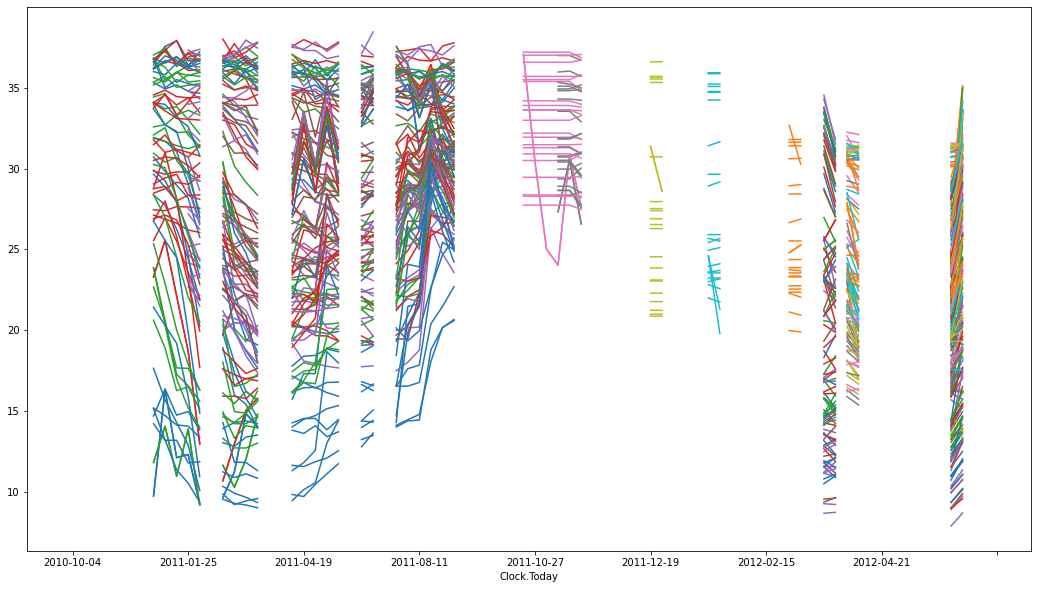

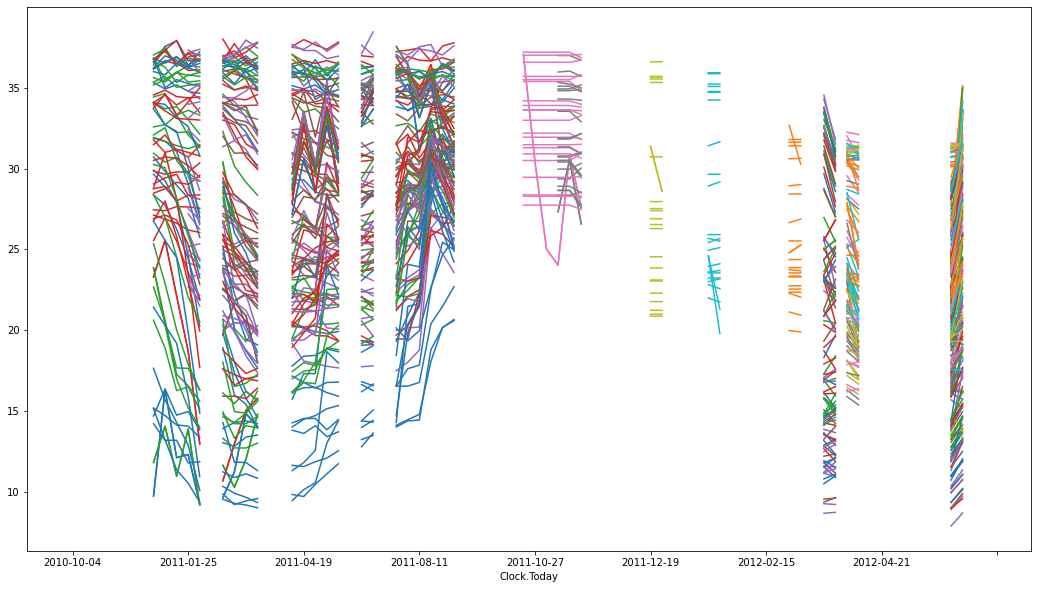

In [34]:
AllTreatmentMeans= SW.groupby(level=['Experiment','Depth','SowingDate'],axis=1).mean()
pos_site = 1

idx = pd.IndexSlice # a slicer to select the column of interest from multiindex
for i in Sites:
    Fig.add_subplot(2,1,pos_site)
    AllTreatmentMeans.loc[: , idx[site, :]].plot(figsize=(18,10), legend = False)
